In [ ]:
!pip install rapidfuzz

In [3]:
import pandas as pd
import re
import spacy
from spacy.training import Example
import random

import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process

In [5]:
df = pd.read_csv("videos.csv")
df.head(10)

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
5,youtube#video,32398,2021-10-06 01:28:59+00:00,39642,body lotion fit tuber 👈|| girls body lotion 👆|...,NaN,"['body lotion fit tuber', 'fit tuber body loti...",NaN,NaN,PT17S,1366.0,15.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
6,youtube#video,90721,2021-02-02 13:04:11+00:00,25860,"Contour Tutorial / How to do Contouring, Blush...",Makeup and Hair by @jagrutililawala\n\n#bride ...,NaN,NaN,NaN,PT1M34S,41.0,2.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
7,youtube#video,77725,2022-11-14 20:58:31+00:00,27788,Best look comes from the best products! #best ...,www.sopoli10x.com \n\n Beauty &Fashion. We re...,NaN,NaN,NaN,PT30S,1859.0,42.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
8,youtube#video,81779,2025-05-08 10:52:09+00:00,7310,Finishing touches. #blackgirlmakeup#makeup#bla...,NaN,NaN,NaN,NaN,PT30S,606.0,4.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
9,youtube#video,43693,2025-06-19 01:45:26+00:00,47519,glowup tips ✨️ #jenny #kpop #skincare #skincar...,#JennyGlowUp\n#KpopGlowUp\n#BeforeVsAfter\n#Gl...,NaN,en,en,PT11S,8951.0,172.0,0.0,5.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


### Data Cleaning

In [6]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove punctuation
    text = text.lower()
    return text

# Merge title, description, and tags into a single 'text' column (raw)
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['tags'].fillna('')
)

# Now clean it into 'clean_text'
df['clean_text'] = df['text'].apply(clean_text)

# Preview
df[['text', 'clean_text']].head(5)

,text,clean_text
0,Unlocking the Benefits of Face Masks for Skin ...,unlocking the benefits of face masks for skin ...
1,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,get ready for the magic hydration glowingskin ...
2,#trending #makeup #beautymakeup #yslbeauty #lu...,trending makeup beautymakeup yslbeauty luxury ...
3,#shortvedio #balayage,shortvedio balayage
4,Full Face of Merit Beauty 🤎 featuring new Flus...,full face of merit beauty featuring new flush...


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,text,clean_text,products
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http...",Unlocking the Benefits of Face Masks for Skin ...,unlocking benefits face masks skin health,[face mask]
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,get ready hydration glowingskin nomakeuplook s...,[]
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#trending #makeup #beautymakeup #yslbeauty #lu...,trending makeup beautymakeup yslbeauty luxury ...,[]
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#shortvedio #balayage,shortvedio balayage,[]
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Full Face of Merit Beauty 🤎 featuring new Flus...,full face merit beauty featuring new flush bal...,[]


### Spacy to extract products and brands

In [ ]:
TRAIN_DATA = [
    ("I love foundation and lipstick",
     {"entities": [(8, 17, "PRODUCT"), (23, 30, "PRODUCT")]}),

    ("lipstick and foundation are my faves",
     {"entities": [(0, 8, "PRODUCT"), (14, 23, "PRODUCT")]}),

    ("blush is amazing today",
     {"entities": [(0, 5, "PRODUCT")]}),

    ("perfume smells nice",
     {"entities": [(0, 7, "PRODUCT")]}),

    ("I just bought mascara & lipstick",
     {"entities": [(15, 21, "PRODUCT"), (25, 32, "PRODUCT")]}),

    ("highlighter, contour palette!",
     {"entities": [(0, 11, "PRODUCT"), (14, 29, "PRODUCT")]}),

    ("eyeshadow, blush, eyeliner",
     {"entities": [(0, 9, "PRODUCT"), (12, 16, "PRODUCT"), (19, 26, "PRODUCT")]}),

    ("lipstick lasts, mascara too",
     {"entities": [(0, 8, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("skincare moisturizer & blush",
     {"entities": [(0, 8, "PRODUCT"), (24, 28, "PRODUCT")]}),

    ("foundation is amazing",
     {"entities": [(0, 10, "PRODUCT")]}),

    ("eyeshadow palette and lip gloss",
     {"entities": [(0, 17, "PRODUCT"), (23, 31, "PRODUCT")]}),

    ("lip balm; concealer",
     {"entities": [(0, 9, "PRODUCT"), (12, 20, "PRODUCT")]}),

    ("eyebrow pencil, blush compact",
     {"entities": [(0, 14, "PRODUCT"), (17, 21, "PRODUCT")]}),

    ("mascara eyeliner",
     {"entities": [(0, 7, "PRODUCT"), (9, 16, "PRODUCT")]}),

    ("lip gloss, bronzer",
     {"entities": [(0, 9, "PRODUCT"), (12, 18, "PRODUCT")]}),

    ("foundation + lipstick",
     {"entities": [(0, 10, "PRODUCT"), (14, 21, "PRODUCT")]}),

    ("fragrance, lip balm, perfume",
     {"entities": [(0, 9, "PRODUCT"), (12, 19, "PRODUCT"), (22, 28, "PRODUCT")]}),

    ("blush, eyeliner, mascara",
     {"entities": [(0, 5, "PRODUCT"), (8, 15, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("bb cream, compact shell, brow pomade",
     {"entities": [(0, 8, "PRODUCT"), (11, 23, "PRODUCT"), (26, 36, "PRODUCT")]}),

    ("hip oil, bb cream, concealer",
     {"entities": [(0, 7, "PRODUCT"), (10, 17, "PRODUCT"), (20, 29, "PRODUCT")]}),

    ("hypercurl mascara, cheeky glow blush",
     {"entities": [(11, 17, "PRODUCT"), (32, 36, "PRODUCT")]}),

    ("megaglow highlighter, colorstay lip color",
     {"entities": [(10, 21, "PRODUCT")]}),

    ("benefits of face masks for skin health",
     {"entities": [(13, 22, "PRODUCT")]}),

    ("body serum",
     {"entities": [(0, 11, "PRODUCT")]}),

    ("deep conditioning like dancing shower shorts, deepconditioning",
     {"entities": [(0, 21, "PRODUCT"), (43, 63, "PRODUCT")]}),

    ("natural looking bronzer, orange bronzer",
     {"entities": [(17, 23, "PRODUCT"), (33, 39, "PRODUCT")]}),

    ("After trying the new highlighter and contour palette, my makeup looks amazing",
     {"entities": [(22, 32, "PRODUCT"), (38, 44, "PRODUCT")]}),

    ("Eyebrow pencil, blush compact, and lip gloss are all essentials in my kit",
     {"entities": [(0, 16, "PRODUCT"), (19, 23, "PRODUCT"), (38, 46, "PRODUCT")]}),

    ("Finally got the bb cream, compact shell, brow pomade, and body serum; my skin is loving it today",
     {"entities": [(17, 24, "PRODUCT"), (27, 39, "PRODUCT"), (42, 52, "PRODUCT"), (59, 68, "PRODUCT")]}),

    ("Trying out deep conditioning like dancing shower shorts and washday deepconditioning for the first time, feels so soft",
     {"entities": [(12, 28, "PRODUCT")]}),

    ("Natural looking bronzer, orange bronzer, hip oil, rose hip oil, and bb cream have been my go-to products this week",
     {"entities": [(17, 23, "PRODUCT"), (33, 39, "PRODUCT"), (42, 48, "PRODUCT"), (51, 62, "PRODUCT"), (69, 76, "PRODUCT")]}),

    ("Unlocking the benefits of face masks for skin health, body serum, and moisturizer has improved my daily routine",
     {"entities": [(27, 36, "PRODUCT"), (55, 64, "PRODUCT"), (70, 81, "PRODUCT")]}),

    ("Megaglow highlighter, colorstay lip color, cheeky glow blush, and hypercurl mascara have transformed my makeup looks",
     {"entities": [(10, 20, "PRODUCT"), (51, 60, "PRODUCT"), (77, 83, "PRODUCT")]}),

    ("I love Maybelline",
     {"entities": [(7, 17, "BRAND")]}),

    ("MAC is my go-to for makeup",
     {"entities": [(0, 3, "BRAND")]}),

    ("Nothing beats Fenty Beauty",
     {"entities": [(14, 26, "BRAND")]}),

    ("Sephora has great deals today",
     {"entities": [(0, 7, "BRAND")]}),

    ("I always trust L'Oreal products",
     {"entities": [(14, 20, "BRAND")]}),

    # --- Brands + Products ---
    ("Maybelline mascara is the best",
     {"entities": [(0, 10, "BRAND"), (11, 18, "PRODUCT")]}),

    ("MAC lipstick lasts all day",
     {"entities": [(0, 3, "BRAND"), (4, 12, "PRODUCT")]}),

    ("Fenty Beauty foundation matches me perfectly",
     {"entities": [(0, 12, "BRAND"), (13, 23, "PRODUCT")]}),

    ("I just bought L'Oreal blush",
     {"entities": [(13, 19, "BRAND"), (20, 25, "PRODUCT")]}),

    ("Sephora sells amazing eyeshadow palettes",
     {"entities": [(0, 7, "BRAND"), (21, 30, "PRODUCT")]}),
]


In [ ]:
!pip install spacy-lookups-data
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")

ner.add_label("PRODUCT")
ner.add_label("BRAND")

1

In [ ]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()

    for epoch in range(100):  # you can increase epochs for better results
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.4, sgd=optimizer, losses=losses)
        print(f"Epoch {epoch+1}, Losses: {losses}")

nlp.to_disk("beauty_ner_model")

/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I just bought L'Oreal blush" with entities "[(13, 19, 'BRAND'), (20, 25, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "lipstick and foundation are my faves" with entities "[(0, 8, 'PRODUCT'), (14, 23, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Eyebrow pencil, blush compact, and lip gloss are

Epoch 1, Losses: {'ner': np.float32(140.88625)}
Epoch 2, Losses: {'ner': np.float32(49.859806)}
Epoch 3, Losses: {'ner': np.float32(38.887142)}
Epoch 4, Losses: {'ner': np.float32(36.423035)}
Epoch 5, Losses: {'ner': np.float32(30.3106)}
Epoch 6, Losses: {'ner': np.float32(23.520182)}
Epoch 7, Losses: {'ner': np.float32(32.86065)}
Epoch 8, Losses: {'ner': np.float32(22.903532)}
Epoch 9, Losses: {'ner': np.float32(35.03483)}
Epoch 10, Losses: {'ner': np.float32(15.728063)}
Epoch 11, Losses: {'ner': np.float32(11.343033)}
Epoch 12, Losses: {'ner': np.float32(10.250488)}
Epoch 13, Losses: {'ner': np.float32(6.694175)}
Epoch 14, Losses: {'ner': np.float32(5.4603415)}
Epoch 15, Losses: {'ner': np.float32(2.2302191)}
Epoch 16, Losses: {'ner': np.float32(4.6147156)}
Epoch 17, Losses: {'ner': np.float32(5.5916586)}
Epoch 18, Losses: {'ner': np.float32(4.701474)}
Epoch 19, Losses: {'ner': np.float32(4.648748)}
Epoch 20, Losses: {'ner': np.float32(2.5773916)}
Epoch 21, Losses: {'ner': np.float32

In [ ]:
nlp2 = spacy.load("beauty_ner_model")

text = "washday deep conditioning like lipstick dancing shower shorts"
doc = nlp2(text)

for ent in doc.ents:
    print(ent.text, ent.label_)


washday PRODUCT


In [ ]:
nlp = spacy.load("beauty_ner_model")

def extract_entities(text):
    doc = nlp(text)
    products = [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]
    brands = [ent.text for ent in doc.ents if ent.label_ == "BRAND"]
    return products, brands

df[['products', 'brands']] = df['clean_text'].apply(
    lambda x: pd.Series(extract_entities(x))
)

In [ ]:
df.to_csv("youtube_beauty_products.csv", index=False)

Most mentioned products

/tmp/ipython-input-932095095.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='product', y='count', data=top_10, palette='viridis')


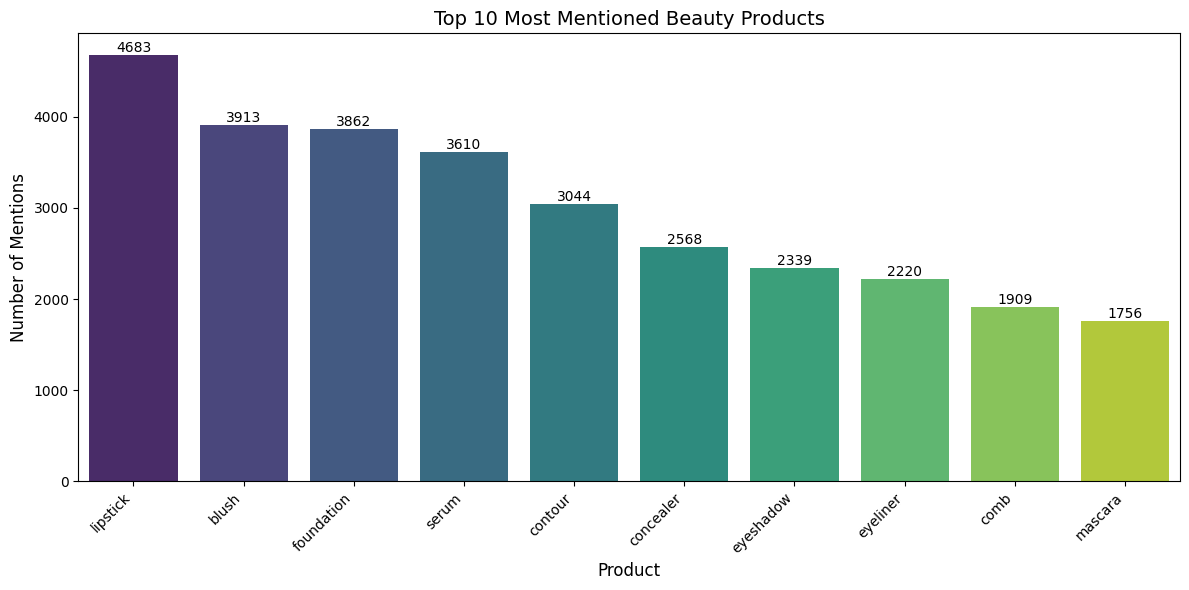

In [ ]:
all_products = [prod for sublist in df['products'].dropna() for prod in set(sublist)]  # remove duplicates per video
product_counts = Counter(all_products)

# Convert to DataFrame
product_counts_df = pd.DataFrame(product_counts.items(), columns=['product', 'count'])
product_counts_df = product_counts_df.sort_values(by='count', ascending=False)

# Top 10
top_10 = product_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='product', y='count', data=top_10, palette='viridis')

# Add counts on top of bars
for p in ax.patches:  # iterate over bars
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Most Mentioned Beauty Products", fontsize=14)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Number of Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_100_products = product_counts_df.head(100)

top_100_products_dict = top_100_products.to_dict(orient="records")

with open("top_100_products.json", "w", encoding="utf-8") as f:
    json.dump(top_100_products_dict, f, ensure_ascii=False, indent=2)

/tmp/ipython-input-1858069270.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')


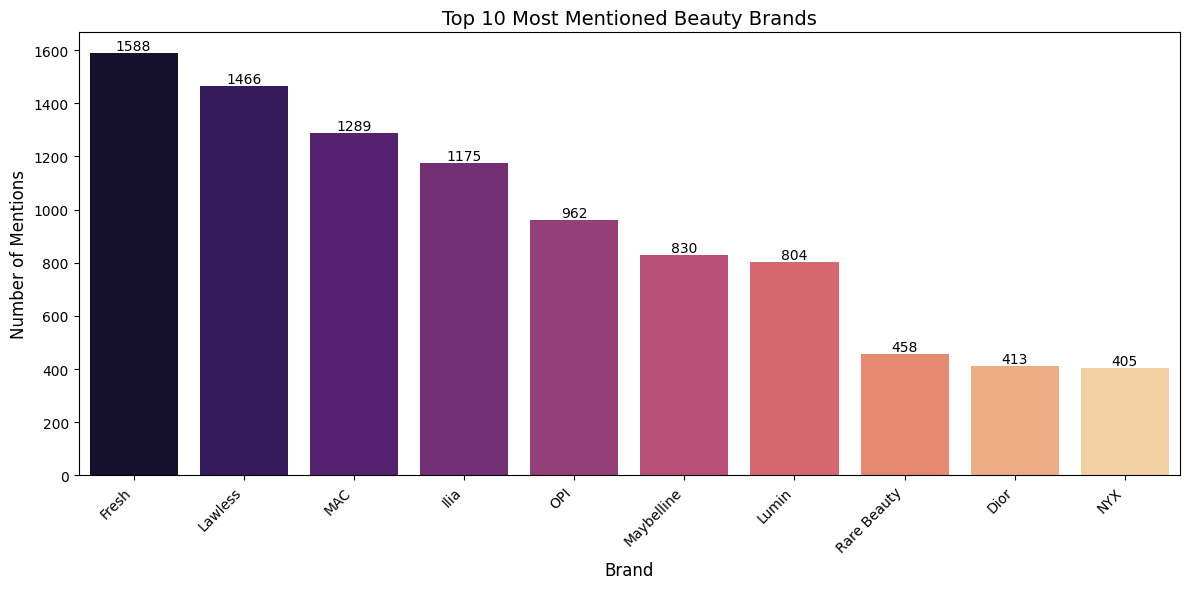

In [ ]:
all_brands = [brand for sublist in df['brands'].dropna() for brand in set(sublist)]  # remove duplicates per video
brand_counts = Counter(all_brands)

brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['brand', 'count'])
brand_counts_df = brand_counts_df.sort_values(by='count', ascending=False)

# Top 10 brands
top_10_brands = brand_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')

# Add counts on top
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Most Mentioned Beauty Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Number of Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_100_brands = brand_counts_df.head(100)

top_100_dict = top_100_brands.to_dict(orient="records")

with open("top_100_brands.json", "w", encoding="utf-8") as f:
    json.dump(top_100_dict, f, ensure_ascii=False, indent=2)

### Predicted Trending Products and Brands

In [10]:
import pandas as pd
import re

# Load CSV files
df_beauty = pd.read_csv("youtube_beauty_products1.csv")  # beauty file
df_trend = pd.read_csv("trend_both_youtube.csv")        # trend file

# --- Normalize products/brands from beauty file ---
def normalize_list(col):
    if pd.isna(col):
        return []
    if isinstance(col, str):
        col = col.strip("[]")
        return [c.strip().strip("'\"") for c in col.split(",") if c.strip()]
    if isinstance(col, list):
        return col
    return []

df_beauty['products'] = df_beauty['products'].apply(normalize_list)
df_beauty['brands']   = df_beauty['brands'].apply(normalize_list)

# --- Extract hashtags from text ---
def extract_hashtags(text):
    return re.findall(r"#(\w+)", str(text))

# --- Initialize columns in trend file ---
df_trend['products'] = [[] for _ in range(len(df_trend))]
df_trend['brands']   = [[] for _ in range(len(df_trend))]

# --- Merge products & brands into trend file (keep duplicates) ---
for idx_trend, trend_row in df_trend.iterrows():
    trend_id = str(trend_row['trend_id']).lstrip("#")  # remove extra # to match hashtags

    for _, beauty_row in df_beauty.iterrows():
        text_hashtags = extract_hashtags(beauty_row['text'])  # or 'clean_text'

        if trend_id in text_hashtags:
            df_trend.at[idx_trend, 'products'].extend(beauty_row['products'])
            df_trend.at[idx_trend, 'brands'].extend(beauty_row['brands'])

# --- Convert lists to strings for saving ---
df_trend['products'] = df_trend['products'].apply(lambda x: ', '.join(x))
df_trend['brands']   = df_trend['brands'].apply(lambda x: ', '.join(x))

# --- Save updated file ---
df_trend.to_csv("trend_both_youtube_updated.csv", index=False, encoding="utf-8-sig")
print("✅ Updated trend file saved as trend_both_youtube_updated.csv")

# Preview
df_trend[['trend_id', 'products', 'brands']].head(10)

✅ Updated trend file saved as trend_both_youtube_updated.csv


,trend_id,products,brands
0,##shorts,"moisturizer, body lotion, body moisturizer, fa...","Fresh, Pixi, Maybelline, Fresh, Laneige, Chane..."
1,##makeup,"bronzer, contour, lipstick, lipstick, eyeliner...","Chanel, Rare Beauty, Rare Beauty, NYX, MAC, La..."
2,##yoga,"gua sha, gua sha, comb, contour, contour, gua ...","OPI, Ilia, Bulldog, OPI, OPI, MAC, OPI, Ilia, ..."
3,##facelift,"gua sha, contour, contour, gua sha, contour, b...","Ilia, OPI, MAC, Innisfree, Laneige, CosRX, Law..."
4,##beauty,"foundation, lipstick, mascara, eyeshadow, blus...","Maybelline, MAC, OPI, Chanel, Urban Decay, Nat..."
5,##skincare,"face powder, face powder, blush, lipstick, eye...","Rare Beauty, Rare Beauty, OPI, Ilia, Bulldog, ..."
6,##youtubeshorts,"face mask, foundation, blush, hair mask, found...","Fresh, Chanel, Ilia, Maybelline, Huda Beauty, ..."
7,##trending,"lipstick, eyeliner, eyeshadow, face mask, hair...","Pixi, Laneige, Bulldog, Maybelline, MAC, MAC, ..."
8,##wrinkles,"gua sha, jade roller, gua sha, comb, contour, ...","Innisfree, Laneige, CosRX, OPI, OPI, MAC, MAC,..."
9,##faceyoga,"gua sha, gua sha, comb, contour, contour, gua ...","OPI, Ilia, Bulldog, OPI, OPI, OPI, OPI, Ilia, ..."


/tmp/ipython-input-3715366179.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='product', y='count', data=top_10_products, palette='viridis')


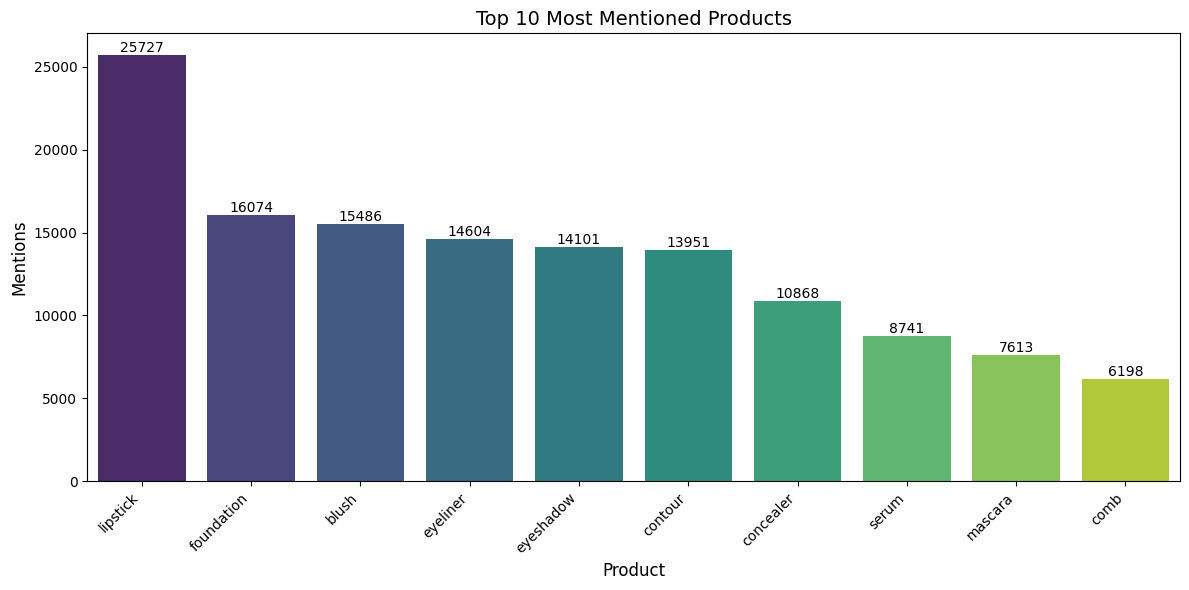

In [11]:
df_trend = pd.read_csv("trend_both_youtube_updated.csv")

# --- Normalize helper ---
def normalize_list(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, str):
        return [c.strip() for c in cell.split(",") if c.strip()]
    return cell

df_trend['products'] = df_trend['products'].apply(normalize_list)
df_trend['brands']   = df_trend['brands'].apply(normalize_list)

# --- PRODUCTS ---
all_products = [prod for sublist in df_trend['products'] for prod in sublist]
product_counts = Counter(all_products)
product_counts_df = pd.DataFrame(product_counts.items(), columns=['product', 'count']).sort_values(by='count', ascending=False)

top_10_products = product_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='product', y='count', data=top_10_products, palette='viridis')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height), ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Most Mentioned Products", fontsize=14)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-100616087.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')


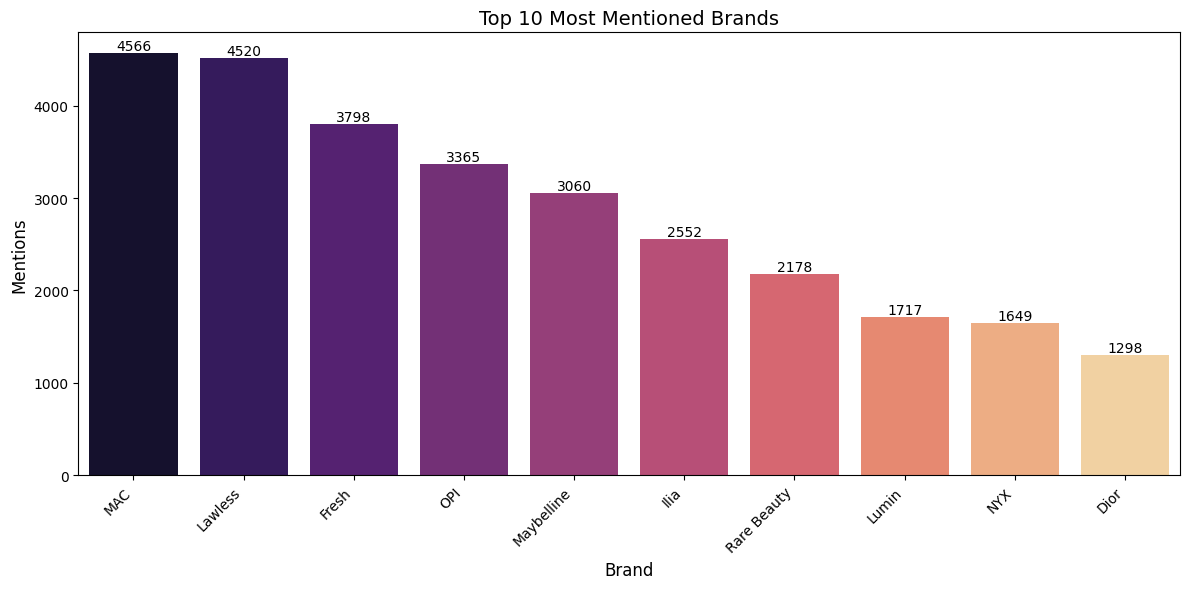

In [12]:
all_brands = [brand for sublist in df_trend['brands'] for brand in sublist]
brand_counts = Counter(all_brands)
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['brand', 'count']).sort_values(by='count', ascending=False)

top_10_brands = brand_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height), ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Most Mentioned Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
import json

trend_100_products = product_counts_df.head(100).to_dict(orient="records")
trend_100_brands   = brand_counts_df.head(100).to_dict(orient="records")

with open("trend_100_products.json", "w", encoding="utf-8") as f:
    json.dump(trend_100_products, f, ensure_ascii=False, indent=2)

with open("trend_100_brands.json", "w", encoding="utf-8") as f:
    json.dump(trend_100_brands, f, ensure_ascii=False, indent=2)

print("Saved top 100 products and brands to JSON files.")

Saved top 100 products and brands to JSON files.


### Match trends with Loreal Products

In [ ]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

In [ ]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

# === Load files ===
csv_path = "trend_both_youtube_updated.csv"
brands_path = "loreal_brands.json"
products_path = "loreal_products.json"

df = pd.read_csv(csv_path)

with open(brands_path, "r", encoding="utf-8") as f:
    brands_data = json.load(f)

with open(products_path, "r", encoding="utf-8") as f:
    products_data = json.load(f)

# === Flatten brand data ===
brand_list = []
for category, items in brands_data.items():
    for b in items:
        brand_list.append({
            "brand": b["brand"],
            "description": b["description"],
            "category": category
        })

# === Flatten product data ===
product_list = [{"title": p["title"], "description": p["description"]} for p in products_data]

# === Matching functions ===
def get_best_product(products_str):
    """Return the single best-matching L'Oréal product"""
    if pd.isna(products_str):
        return None

    products = [p.strip().lower() for p in products_str.split(",")]
    best_score = 0
    best_product = None

    for prod in products:
        for item in product_list:
            score_title = fuzz.partial_ratio(prod, item["title"].lower())
            score_desc = fuzz.partial_ratio(prod, item["description"].lower())
            score = max(score_title, score_desc)
            if score > best_score:
                best_score = score
                best_product = item["title"]
    return best_product

def get_best_brands(trend_id, products_str, top_n=3):
    """Return 1–3 best-matching brands"""
    text = (str(trend_id) + " " + str(products_str)).lower()
    scored = []
    for b in brand_list:
        score_brand = fuzz.partial_ratio(b["brand"].lower(), text)
        score_desc = fuzz.partial_ratio(b["description"].lower(), text)
        score = max(score_brand, score_desc)
        if score > 50:  # relevance threshold
            scored.append((b["brand"], score))
    scored = sorted(scored, key=lambda x: x[1], reverse=True)
    best_brands = [s[0] for s in scored[:top_n]]
    return best_brands if best_brands else None

# === Apply to dataset ===
df["best_loreal_product"] = df["products"].apply(get_best_product)
df["best_brands"] = df.apply(lambda x: get_best_brands(x["trend_id"], x["products"]), axis=1)

# === Save result ===
output_path = "trend_with_loreal_mapping.csv"
df.to_csv(output_path, index=False)

print(f"✅ New CSV saved to {output_path}")

✅ New CSV saved to trend_with_loreal_mapping.csv


In [ ]:
df.head(5)

,trend_id,token_type,platform,date,volume,engagement,audience_signals,category,geo,raw_token,growth_rate_7d,acceleration,current_stage,recommended_action,products,best_loreal_product,best_brands
0,##shorts,hashtag,youtube,2025-09-07,9739,37255097,"{'gen_z': np.float64(0.75), 'millennials': np....","['lifestyle', 'health', 'general']","['hi', 'en', 'ru', 'ur', 'en-GB', 'en-IN', 'en...",##shorts,-0.111,0.667,peak,Maintain visibility,"moisturizer, body lotion, face powder, lipstic...",Glycolic Bright\nGlycolic Bright 8% [Melasyl ™...,"[Garnier, Maybelline New York, NYX Professiona..."
1,##makeup,hashtag,youtube,2025-09-07,4091,70248158,"{'gen_z': np.float64(0.46), 'millennials': np....","['lifestyle', 'general', 'health']","['en', 'en-GB', 'hi', 'en-IN', 'ml', 'es', 'id...",##makeup,0.000,-0.333,declining,Too late,"bronzer, contour, lipstick, eyeliner, eyeshado...",Infallible Lip Makeup\nInfallible Matte Resist...,"[Garnier, Maybelline New York]"
2,##yoga,hashtag,youtube,2025-09-07,3075,1352141,"{'gen_z': np.float64(0.49), 'millennials': np....","['health', 'lifestyle', 'general']","['hi', 'en', 'en-IN', 'zxx']",##yoga,1.000,0.333,emerging,Hop on now,"gua sha, comb, contour, lipstick, serum, acne ...",Glycolic Bright\nAnti-Dark Spot Exfoliant Peel,"[Essie, Armani Beauty, Maison Margiela]"
3,##facelift,hashtag,youtube,2025-09-07,2407,616522,"{'gen_z': np.float64(0.66), 'millennials': np....","['health', 'lifestyle']","['en-US', 'es', 'en', 'zxx', 'hi']",##facelift,0.000,0.667,peak,Maintain visibility,"gua sha, contour, blush, bronzer, highlighter,...",Infallible\nFull Wear More Than Concealer,"[CeraVe, Garnier]"
4,##beauty,hashtag,youtube,2025-09-07,2038,44001722,"{'gen_z': np.float64(0.44), 'millennials': np....","['lifestyle', 'general', 'health']","['en-US', 'en', 'hi', 'en-IN', 'en-GB', 'id', ...",##beauty,0.000,0.000,declining,Too late,"foundation, lipstick, mascara, eyeshadow, blus...",Infallible\n32H FreshWear Foundation,"[Carita, Valentino, Urban Decay]"
